In [78]:
import os
from joblib import Parallel, delayed
import argparse
import numpy as np
import joblib
from econml.dr import DRLearner
from sklearn.model_selection import train_test_split
from econml.dml import NonParamDML
from matplotlib import pyplot as plt
import warnings
from sklearn.linear_model import Ridge
warnings.simplefilter('ignore')

#here we replicate steup A, sigma is the standard deviation of the noise
def gen_data(n,d, base_fn, tau_fn, prop_fn, sigma):
    X = np.random.uniform(0,1, size = (n,d))
    X_test = np.random.uniform(0,1, size = (10000, d)) #regardless of train size, we always use 10000 test samples
    T = np.random.binomial(1, prop_fn(X)) #here, 1 refers to number of trials, 1 reduces the binomial distribution to a bernoulli distribution
    y = (T - .5)*tau_fn(X) + base_fn(X) + sigma*np.random.normal(0,1, size = (n,))
    return y, T, X, X_test

def get_data_generator(n, d, sigma):
        def base_fn(X): return np.sin(np.pi * X[:, 0] * X[:, 1]) + 2*(X[:, 2] - .5)**2 + X[:, 3] + .5*X[:, 4]
        def prop_fn(X): return np.clip(
            np.sin(np.pi * X[:, 0] * X[:, 1]), .2, .8)
        def tau_fn(X): return .2 + (X[:, 0] + X[:, 1]) / 2
        def gen_data_fn(): return gen_data(
            n, d, base_fn, tau_fn, prop_fn, sigma)
        return gen_data_fn, base_fn, tau_fn, prop_fn

def rmse(ytrue, y):
    return np.sqrt(np.mean((ytrue.flatten() - y.flatten())**2))

def exp(y, T, X, Xtest, method_list, tau_fn, n_x):
    results = {}
    for name, method in method_list:
        #print(name)
        tau_est, _ = method(y, T, X, Xtest, n_x)
        results[name] = rmse(tau_fn(Xtest), tau_est)**2 #mse results
        # print(results[name])
        # print('-'*10)
        bias = np.mean(tau_est - tau_fn(Xtest)) #average bias over the test set
        var_bias = np.var(tau_est - tau_fn(Xtest)) #variance of the bias
    return results, bias, var_bias

from flaml import AutoML
from sklearn.base import BaseEstimator, clone

class AutoMLWrap(BaseEstimator):
    def __init__(self, *, model):
        self.model = model
    def fit(self, X, y, **kwargs):
        self.model_ = clone(self.model)
        self.model_.fit(X, y, **kwargs)
        return self
    def predict(self, X):
        return self.model_.predict(X)
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

def first_stage_reg(X, y): #predicting the base response function
    automl = AutoML(task='regression', time_budget=60, early_stop=True,
                    eval_method='cv', n_splits=5, metric='mse', verbose=0)
    automl.fit(X, y)
    best_est = automl.best_estimator 
    return AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))

def first_stage_clf(X, y): #predicting the propensities
    automl = AutoML(task='classification', time_budget=60, early_stop=True,
                    eval_method='cv', n_splits=5, metric='mse', verbose=0)
    automl.fit(X, y)
    best_est = automl.best_estimator
    return AutoMLWrap(model=clone(automl.best_model_for_estimator(best_est)))

def weighted_mse(
        X_val, y_val, estimator, labels,
        X_train, y_train, weight_val=None, weight_train=None,
        *args,):
    y_pred = estimator.predict(X_val)
    weight_val = 1 if weight_val is None else weight_val
    weight_train = 1 if weight_train is None else weight_train
    error = (estimator.predict(X_val) - y_val)**2
    val_loss = np.mean(weight_val * error)
    error_train = (estimator.predict(X_train) - y_train)**2
    train_loss = np.mean(weight_train * error_train)
    return val_loss, {"val_loss": val_loss, "train_loss": train_loss}

def final_stage():
    return AutoMLWrap(model=AutoML(task='regression', time_budget=60, early_stop=True,
                                   eval_method='cv',
                                   n_splits=10, metric=weighted_mse, verbose=0))

def dml(y, T, X, Xtest, n_x): #10-fold cross-fitting
    est = NonParamDML(model_y='forest',
                      model_t='forest',
                      model_final=final_stage(),
                      discrete_treatment=True,
                      cv=5,
                      random_state=123)
    est.fit(Y=y, T=T, X=X[:, :n_x], W=X[:, n_x:])
    print("models_t",est.models_t)
    print("models_y",est.models_y)
    return est.effect(Xtest[:, :n_x]), est



In [79]:
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(500, 6, 1)
y, T, X, Xtest = gen_data_fn()
print(y.shape, T.shape, X.shape, Xtest.shape)
exp(y, T, X, Xtest, [('dml', dml)], tau_fn, n_x=4)

(500,) (500,) (500, 6) (10000, 6)
models_t [[RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123)]]
models_y [[RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123)]]


({'dml': 0.07098261457758209}, 0.032034638537966065, 0.06995639651132396)

In [65]:
#LGBM version
from lightgbm import LGBMRegressor
import numpy as np
def s_learner(y, T, X, Xtest, n_x):
    model = LGBMRegressor(max_depth=3, min_child_samples=30)
    model.fit(np.hstack((X, T.reshape(-1, 1))), y)
    y0_pred = model.predict(np.hstack((Xtest, np.zeros((Xtest.shape[0], 1)))))
    y1_pred = model.predict(np.hstack((Xtest, np.ones((Xtest.shape[0], 1)))))
    return y1_pred - y0_pred, model


def t_learner(y, T, X, Xtest, n_x):
    # Separate treated and control samples
    X_treated = X[T == 1]
    y_treated = y[T == 1]
    X_control = X[T == 0]
    y_control = y[T == 0]
    
    # Train separate models
    model_treated = LGBMRegressor(max_depth=3, min_child_samples=30)
    model_control = LGBMRegressor(max_depth=3, min_child_samples=30)
    
    model_treated.fit(X_treated, y_treated)
    model_control.fit(X_control, y_control)
    
    # Predict potential outcomes
    y1_pred = model_treated.predict(Xtest)
    y0_pred = model_control.predict(Xtest)
    
    # Calculate treatment effect
    tau_pred = y1_pred - y0_pred
    
    return tau_pred, (model_treated, model_control)


In [62]:
# #random forest version
# from sklearn.ensemble import RandomForestRegressor
# def s_learner(y, T, X, Xtest, n_x):
#     model = RandomForestRegressor(max_depth=3, min_samples_leaf=30)
#     model.fit(np.hstack((X, T.reshape(-1, 1))), y)
#     y0_pred = model.predict(np.hstack((Xtest, np.zeros((Xtest.shape[0], 1)))))
#     y1_pred = model.predict(np.hstack((Xtest, np.ones((Xtest.shape[0], 1)))))
#     return y1_pred - y0_pred, model

# def t_learner(y, T, X, Xtest, n_x):
#     # Separate treated and control samples
#     X_treated = X[T == 1]
#     y_treated = y[T == 1]
#     X_control = X[T == 0]
#     y_control = y[T == 0]
    
#     # Train separate models
#     model_treated = RandomForestRegressor(max_depth=3, min_samples_leaf=30)
#     model_control = RandomForestRegressor(max_depth=3, min_samples_leaf=30)
    
#     model_treated.fit(X_treated, y_treated)
#     model_control.fit(X_control, y_control)
    
#     # Predict potential outcomes
#     y1_pred = model_treated.predict(Xtest)
#     y0_pred = model_control.predict(Xtest)
    
#     # Calculate treatment effect
#     tau_pred = y1_pred - y0_pred
    
#     return tau_pred, (model_treated, model_control)

In [49]:
#lasso version
from sklearn.linear_model import Lasso

def s_learner_lasso(y, T, X, Xtest, n_x):
    model = Lasso(alpha = 0.1)
    model.fit(np.hstack((X, T.reshape(-1, 1))), y)
    y0_pred = model.predict(np.hstack((Xtest, np.zeros((Xtest.shape[0], 1)))))
    y1_pred = model.predict(np.hstack((Xtest, np.ones((Xtest.shape[0], 1)))))
    return y1_pred - y0_pred, model

def t_learner_lasso(y, T, X, Xtest, n_x):
    # Separate treated and control samples
    X_treated = X[T == 1]
    y_treated = y[T == 1]
    X_control = X[T == 0]
    y_control = y[T == 0]
    
    # Train separate models
    model_treated = Lasso(alpha = 0.1)
    model_control = Lasso(alpha = 0.1)
    
    model_treated.fit(X_treated, y_treated)
    model_control.fit(X_control, y_control)
    
    # Predict potential outcomes
    y1_pred = model_treated.predict(Xtest)
    y0_pred = model_control.predict(Xtest)
    
    # Calculate treatment effect
    tau_pred = y1_pred - y0_pred
    
    return tau_pred, (model_treated, model_control)

In [16]:
# import numpy as np
# from sklearn.base import clone
# from econml._cate_estimator import LinearCateEstimator

# class MySLearner(LinearCateEstimator):
    
#     def __init__(self, *, overall_model, final_model):
#         self.overall_model = overall_model
#         self.final_model = final_model
#         return 

#     def fit(self, y, T, X, W=None):
#         XW = X
#         if W is not None:
#             XW = np.hstack([X, W])
#         self.model_ = clone(self.overall_model)
#         self.model_.fit(np.hstack([T.reshape(-1, 1), XW]), y)
#         ones = np.hstack([np.ones((X.shape[0], 1)), XW])
#         zeros = np.hstack([np.zeros((X.shape[0], 1)), XW])
#         diffs = self.model_.predict(ones) - self.model_.predict(zeros)
        
#         self.model_final_ = clone(self.final_model)
#         self.model_final_.fit(X, diffs)
#         return self

#     def effect(self, X, T0=0, T1=1):
#         return self.const_marginal_effect(X)

#     def const_marginal_effect(self, X):
#         return self.model_final_.predict(X)
    
# def myslearner(y, T, X, Xtest, n_x):
#     slearner = MySLearner(overall_model=first_stage_reg(np.hstack([T.reshape(-1, 1), X]), y),
#                           final_model=final_stage())
#     slearner.fit(y, T, X=X[:, :n_x], W=X[:, n_x:])
#     return slearner.effect(Xtest[:, :n_x]), slearner

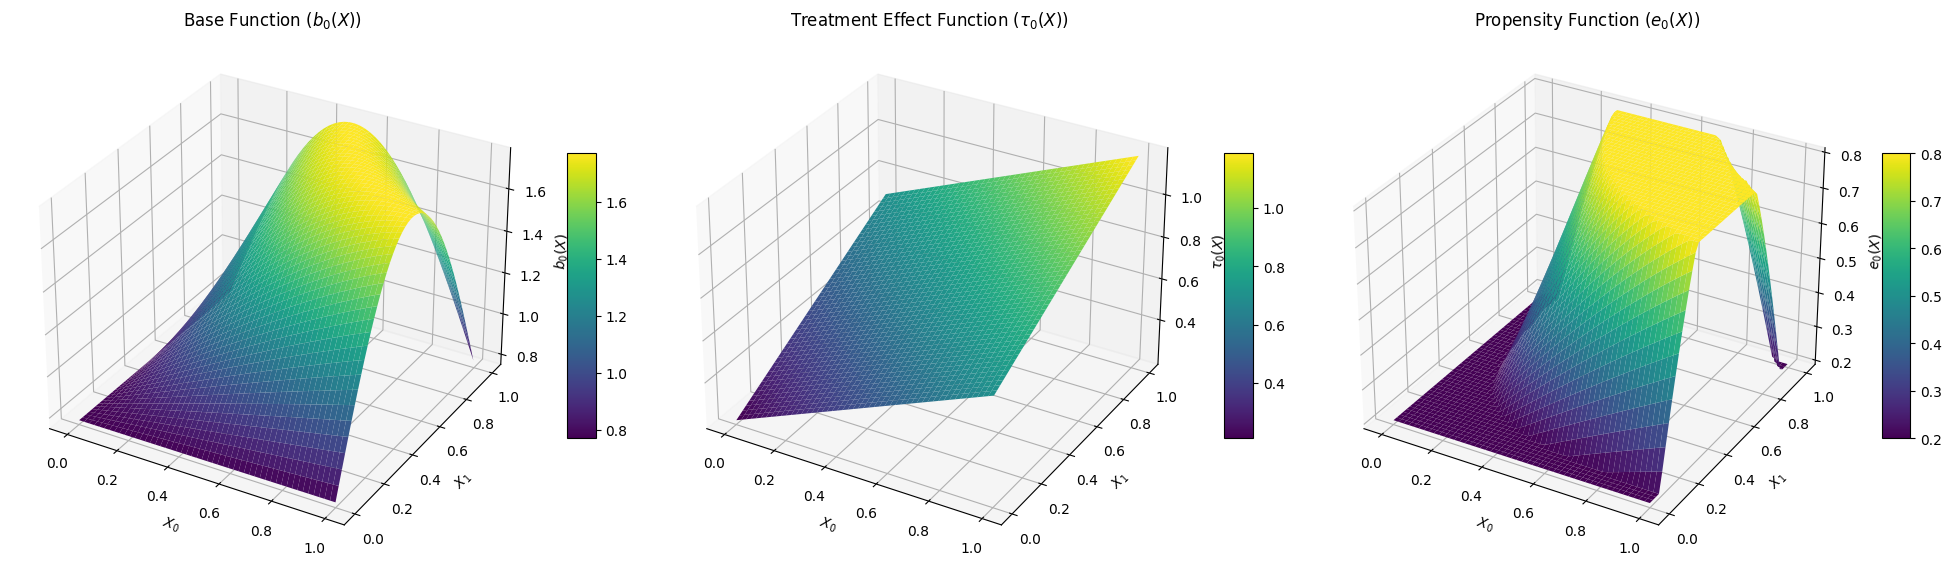

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting tools

# Generate data
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(500, 6, 1)
y, T, X, X_test = gen_data_fn()

# Create a grid for X[0] and X[1]
x0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
x1 = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)
X0, X1 = np.meshgrid(x0, x1)
grid = np.column_stack([X0.ravel(), X1.ravel()] + [np.mean(X[:, i]) * np.ones_like(X0.ravel()) for i in range(2, X.shape[1])])

# Evaluate functions on the grid
base_vals = base_fn(grid).reshape(X0.shape)
tau_vals = tau_fn(grid).reshape(X0.shape)
prop = prop_fn(grid).reshape(X0.shape)

# Define the figure
fig = plt.figure(figsize=(20, 6))

# 3D surface plot for the base function (b_0)
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X0, X1, base_vals, cmap='viridis', edgecolor='none')
ax1.set_title('Base Function ($b_0(X)$)')
ax1.set_xlabel('$X_0$')
ax1.set_ylabel('$X_1$')
ax1.set_zlabel('$b_0(X)$')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# 3D surface plot for the treatment effect (tau_0)
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X0, X1, tau_vals, cmap='viridis', edgecolor='none')
ax2.set_title('Treatment Effect Function ($\\tau_0(X)$)')
ax2.set_xlabel('$X_0$')
ax2.set_ylabel('$X_1$')
ax2.set_zlabel('$\\tau_0(X)$')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

# 3D surface plot for propensity + base function
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X0, X1, prop, cmap='viridis', edgecolor='none')
ax3.set_title('Propensity Function ($e_0(X)$)')
ax3.set_xlabel('$X_0$')
ax3.set_ylabel('$X_1$')
ax3.set_zlabel('$e_0(X)$')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

# Display the plots
plt.tight_layout()
plt.show()


simulated N =  0
simulated N =  10
simulated N =  20
simulated N =  30
simulated N =  40
simulated N =  50
simulated N =  60
simulated N =  70
simulated N =  80
simulated N =  90
simulated N =  100
simulated N =  110
simulated N =  120
simulated N =  130
simulated N =  140
simulated N =  150
simulated N =  160
simulated N =  170
simulated N =  180
simulated N =  190
simulated N =  200
simulated N =  210
simulated N =  220
simulated N =  230
simulated N =  240
simulated N =  250
simulated N =  260
simulated N =  270
simulated N =  280
simulated N =  290
S-Learner: t-statistic = 1.975231024566706, p-value = 0.049161431355754716
T-Learner: t-statistic = 13.736490368669193, p-value = 1.2672501291063367e-33


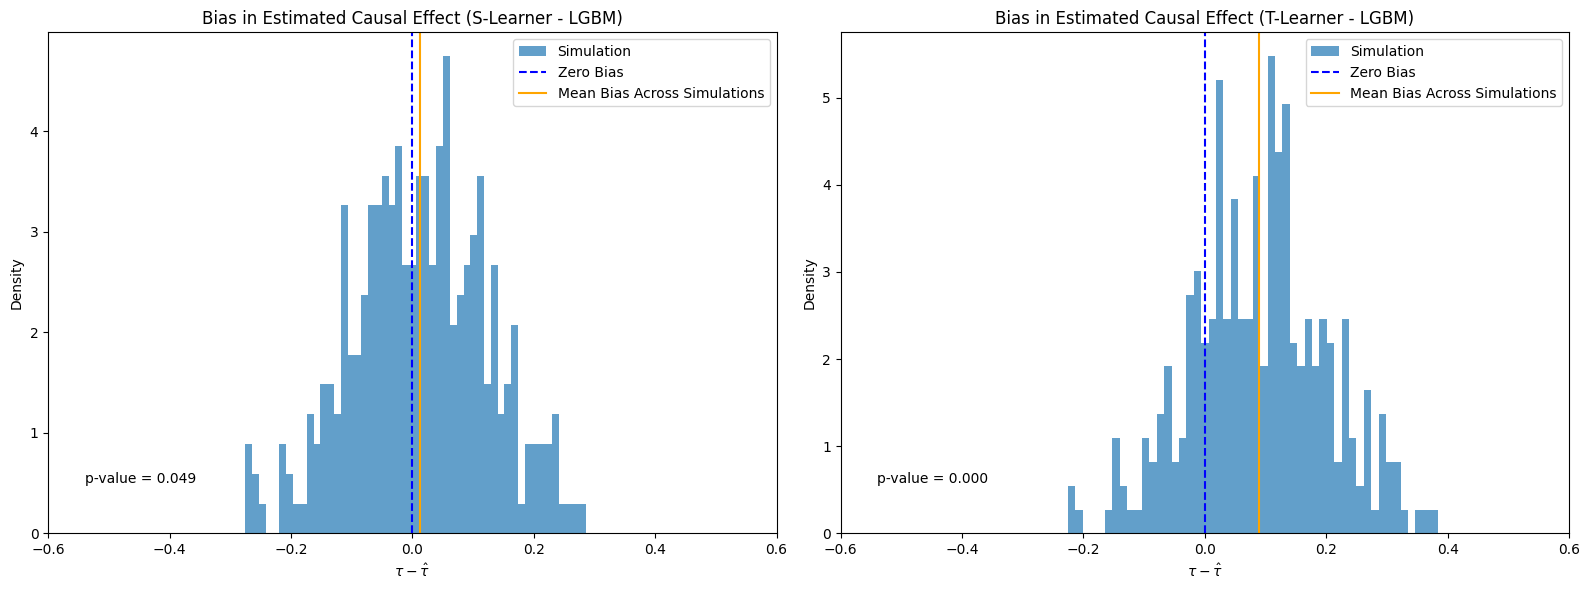

In [70]:
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(500, 6, 1)
n_simulation = 300
bias_lst_s = []
bias_lst_t = []
for i in range(n_simulation):
    y, T, X, Xtest = gen_data_fn()
    mse_results, bias, _ = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=4) #use lgbm regressor
    bias_lst_s.append(bias)
    mse_results, bias, _ = exp(y, T, X, Xtest, [('t-learner', t_learner)], tau_fn, n_x=4) #use lgbm regressor
    bias_lst_t.append(bias)
    if i % 10 == 0:
        print('simulated N = ',i)
#plotting the results bias distributions
# Plot the results

mean_bias_s = np.mean(bias_lst_s)
mean_bias_t = np.mean(bias_lst_t)

# Create a single figure with two horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#set x-axis limits to -0.6 to 0.6
axes[0].set_xlim(-0.6, 0.6)
axes[1].set_xlim(-0.6, 0.6)

# S-Learner Bias Distribution
axes[0].hist(bias_lst_s, bins=50, density=True, alpha=0.7, label="Simulation")
axes[0].axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
axes[0].axvline(x=mean_bias_s, color='orange', linestyle='-', label="Mean Bias Across Simulations")
axes[0].set_title("Bias in Estimated Causal Effect (S-Learner - LGBM)")
axes[0].set_xlabel(r"$\tau - \hat{\tau}$")
axes[0].set_ylabel("Density")
axes[0].legend()

# T-Learner Bias Distribution
axes[1].hist(bias_lst_t, bins=50, density=True, alpha=0.7, label="Simulation")
axes[1].axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
axes[1].axvline(x=mean_bias_t, color='orange', linestyle='-', label="Mean Bias Across Simulations")
axes[1].set_title("Bias in Estimated Causal Effect (T-Learner - LGBM)")
axes[1].set_xlabel(r"$\tau - \hat{\tau}$")
axes[1].set_ylabel("Density")
axes[1].legend()


#t-test whether mean bias is significantly different from 0
from scipy.stats import ttest_1samp
t_stat_s, p_value_s = ttest_1samp(bias_lst_s, 0)
t_stat_t, p_value_t = ttest_1samp(bias_lst_t, 0)
print(f"S-Learner: t-statistic = {t_stat_s}, p-value = {p_value_s}")
print(f"T-Learner: t-statistic = {t_stat_t}, p-value = {p_value_t}")

#add text annotation of p-value
axes[0].text(0.05, 0.1, f"p-value = {p_value_s:.3f}", transform=axes[0].transAxes)
axes[1].text(0.05, 0.1, f"p-value = {p_value_t:.3f}", transform=axes[1].transAxes)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

simulated N =  0
simulated N =  10
simulated N =  20
simulated N =  30
simulated N =  40
simulated N =  50
simulated N =  60
simulated N =  70
simulated N =  80
simulated N =  90
simulated N =  100
simulated N =  110
simulated N =  120
simulated N =  130
simulated N =  140
simulated N =  150
simulated N =  160
simulated N =  170
simulated N =  180
simulated N =  190
simulated N =  200
simulated N =  210
simulated N =  220
simulated N =  230
simulated N =  240
simulated N =  250
simulated N =  260
simulated N =  270
simulated N =  280
simulated N =  290
S-Learner: t-statistic = -14.795909127803222, p-value = 1.5117774443812428e-37
T-Learner: t-statistic = 58.1163024012051, p-value = 5.78530638390782e-165


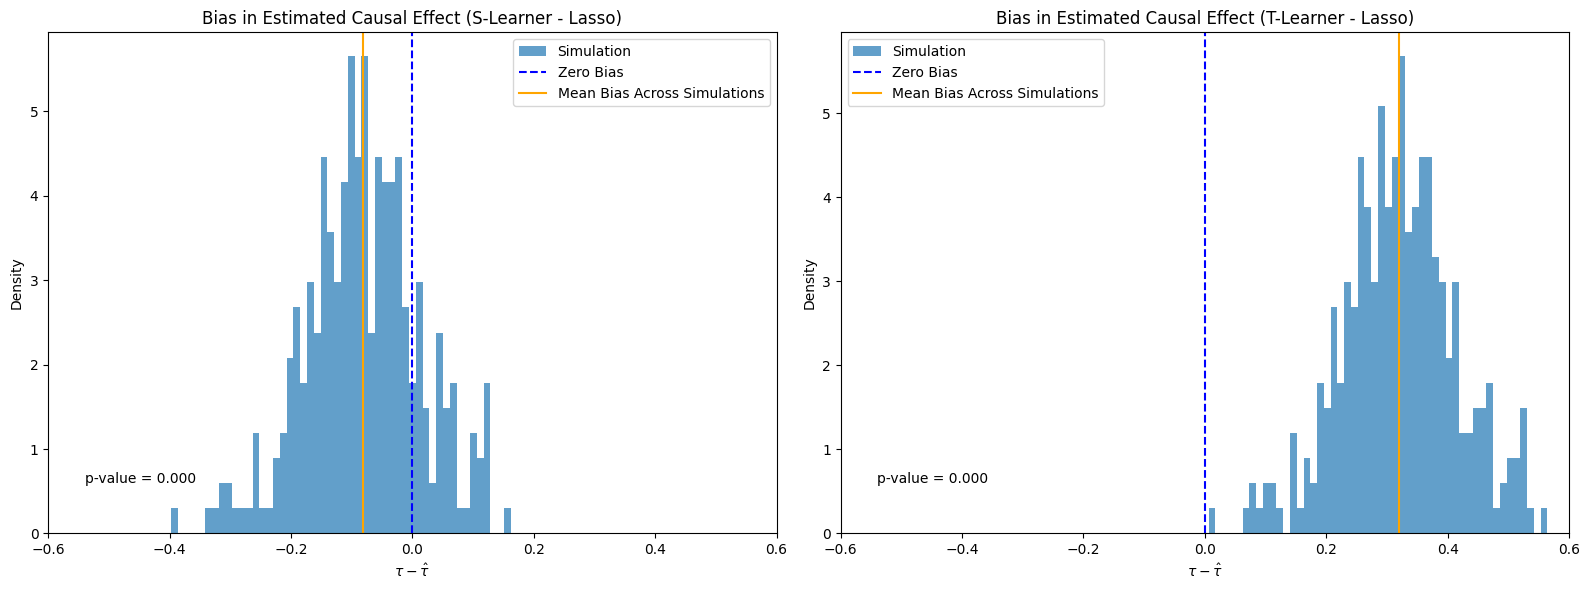

In [71]:
gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(500, 6, 1)
n_simulation = 300
bias_lst_s = []
bias_lst_t = []
for i in range(n_simulation):
    y, T, X, Xtest = gen_data_fn()
    mse_results, bias, _ = exp(y, T, X, Xtest, [('s-learner', s_learner_lasso)], tau_fn, n_x=4) #use lgbm regressor
    bias_lst_s.append(bias)
    mse_results, bias, _ = exp(y, T, X, Xtest, [('t-learner', t_learner_lasso)], tau_fn, n_x=4) #use lgbm regressor
    bias_lst_t.append(bias)
    if i % 10 == 0:
        print('simulated N = ',i)
#plotting the results bias distributions
# Plot the results

mean_bias_s = np.mean(bias_lst_s)
mean_bias_t = np.mean(bias_lst_t)

# Create a single figure with two horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_xlim(-0.6, 0.6)
axes[1].set_xlim(-0.6, 0.6)

# S-Learner Bias Distribution
axes[0].hist(bias_lst_s, bins=50, density=True, alpha=0.7, label="Simulation")
axes[0].axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
axes[0].axvline(x=mean_bias_s, color='orange', linestyle='-', label="Mean Bias Across Simulations")
axes[0].set_title("Bias in Estimated Causal Effect (S-Learner - Lasso)")
axes[0].set_xlabel(r"$\tau - \hat{\tau}$")
axes[0].set_ylabel("Density")
axes[0].legend()

# T-Learner Bias Distribution
axes[1].hist(bias_lst_t, bins=50, density=True, alpha=0.7, label="Simulation")
axes[1].axvline(x=0, color='blue', linestyle='--', label="Zero Bias")
axes[1].axvline(x=mean_bias_t, color='orange', linestyle='-', label="Mean Bias Across Simulations")
axes[1].set_title("Bias in Estimated Causal Effect (T-Learner - Lasso)")
axes[1].set_xlabel(r"$\tau - \hat{\tau}$")
axes[1].set_ylabel("Density")
axes[1].legend()

#t-test whether mean bias is significantly different from 0
from scipy.stats import ttest_1samp
t_stat_s, p_value_s = ttest_1samp(bias_lst_s, 0)
t_stat_t, p_value_t = ttest_1samp(bias_lst_t, 0)
print(f"S-Learner: t-statistic = {t_stat_s}, p-value = {p_value_s}")
print(f"T-Learner: t-statistic = {t_stat_t}, p-value = {p_value_t}")

#add text annotation of p-value
axes[0].text(0.05, 0.1, f"p-value = {p_value_s:.3f}", transform=axes[0].transAxes)
axes[1].text(0.05, 0.1, f"p-value = {p_value_t:.3f}", transform=axes[1].transAxes)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


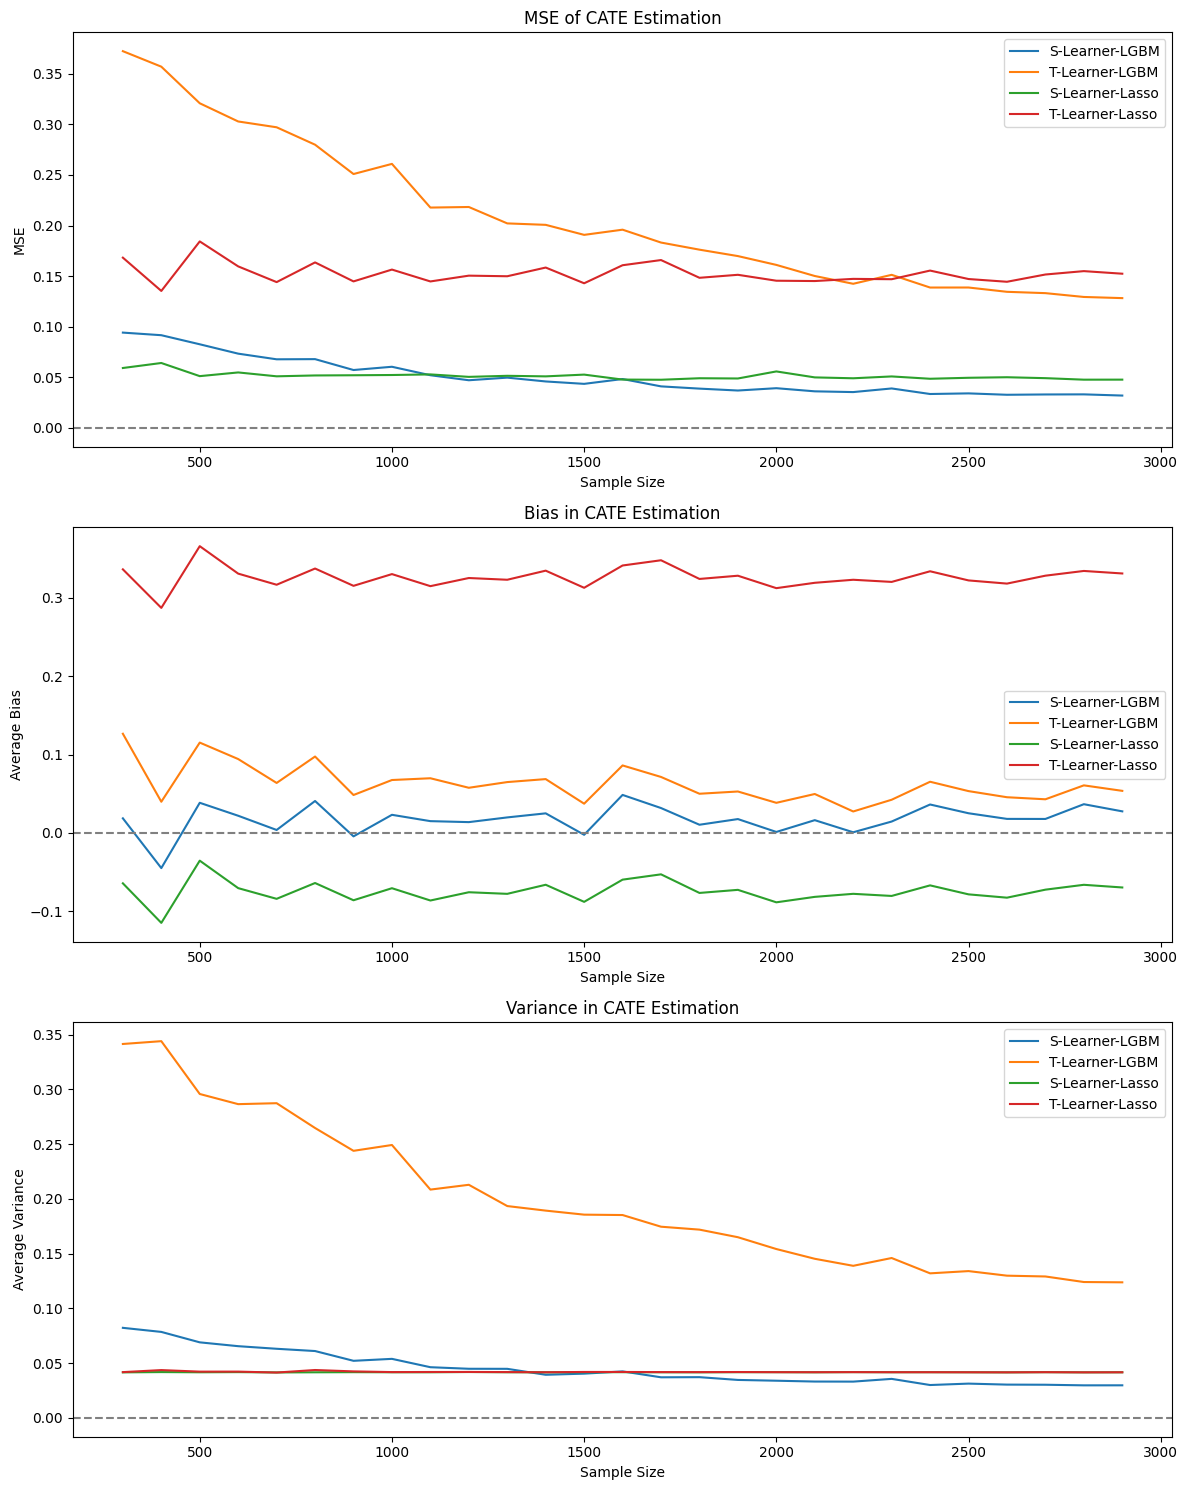

In [75]:
# Convergence rate analysis
n_list = range(300, 3000, 100)
n_simulation = 20

# Initialize results
results = {"mse_s": [], "mse_t": [], "bias_s": [], "bias_t": [], "var_s": [], "var_t": [],
           "mse_s2": [], "mse_t2": [], "bias_s2": [], "bias_t2": [], "var_s2": [], "var_t2": []}

for n in n_list:
    # Temporary storage for simulations
    temp_results = {"s": {"mse": [], "bias": [], "var": []}, "t": {"mse": [], "bias": [], "var": []},
                    "s2": {"mse": [], "bias": [], "var": []}, "t2": {"mse": [], "bias": [], "var": []}}

    for _ in range(n_simulation):
        gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(n, 6, 1)
        y, T, X, Xtest = gen_data_fn()

        # S-Learner
        mse_s, bias_s, var_s = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=4)
        temp_results["s"]["mse"].append(mse_s['s-learner'])
        temp_results["s"]["bias"].append(bias_s)
        temp_results["s"]["var"].append(var_s)

        # T-Learner
        mse_t, bias_t, var_t = exp(y, T, X, Xtest, [('t-learner', t_learner)], tau_fn, n_x=4)
        temp_results["t"]["mse"].append(mse_t['t-learner'])
        temp_results["t"]["bias"].append(bias_t)
        temp_results["t"]["var"].append(var_t)

        # S-Learner with Lasso
        mse_s2, bias_s2, var_s2 = exp(y, T, X, Xtest, [('s-learner', s_learner_lasso)], tau_fn, n_x=4)
        temp_results["s2"]["mse"].append(mse_s2['s-learner'])
        temp_results["s2"]["bias"].append(bias_s2)
        temp_results["s2"]["var"].append(var_s2)

        # T-Learner with Lasso
        mse_t2, bias_t2, var_t2 = exp(y, T, X, Xtest, [('t-learner', t_learner_lasso)], tau_fn, n_x=4)
        temp_results["t2"]["mse"].append(mse_t2['t-learner'])
        temp_results["t2"]["bias"].append(bias_t2)
        temp_results["t2"]["var"].append(var_t2)

    # Aggregate results for current sample size
    results["mse_s"].append(np.mean(temp_results["s"]["mse"]))
    results["mse_t"].append(np.mean(temp_results["t"]["mse"]))
    results["bias_s"].append(np.mean(temp_results["s"]["bias"]))
    results["bias_t"].append(np.mean(temp_results["t"]["bias"]))
    results["var_s"].append(np.mean(temp_results["s"]["var"]))
    results["var_t"].append(np.mean(temp_results["t"]["var"]))
    results["mse_s2"].append(np.mean(temp_results["s2"]["mse"]))
    results["mse_t2"].append(np.mean(temp_results["t2"]["mse"]))
    results["bias_s2"].append(np.mean(temp_results["s2"]["bias"]))
    results["bias_t2"].append(np.mean(temp_results["t2"]["bias"]))
    results["var_s2"].append(np.mean(temp_results["s2"]["var"]))
    results["var_t2"].append(np.mean(temp_results["t2"]["var"]))

# Plot the results in a single figure vertically
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Define plot parameters
metrics = ["mse", "bias", "var"]
titles = [
    "MSE of CATE Estimation",
    "Bias in CATE Estimation",
    "Variance in CATE Estimation",
]
ylabels = ["MSE", "Average Bias", "Average Variance"]

# Iterate over metrics to plot
for i, metric in enumerate(metrics):
    axes[i].plot(n_list, results[f"{metric}_s"], label="S-Learner-LGBM")
    axes[i].plot(n_list, results[f"{metric}_t"], label="T-Learner-LGBM")
    axes[i].plot(n_list, results[f"{metric}_s2"], label="S-Learner-Lasso")
    axes[i].plot(n_list, results[f"{metric}_t2"], label="T-Learner-Lasso")
    axes[i].axhline(y=0 if metric != "mse" else 0, color='gray', linestyle='--')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Sample Size")
    axes[i].set_ylabel(ylabels[i])
    axes[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

models_t [[RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123)]]
models_y [[RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123)]]
models_t [[RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123)]]
models_y [[RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123), RandomForestRegressor(random_state=123)]]
models_t [[RandomForestClassifier(random_state=123), RandomForestClassifier(random_state=123), RandomForestClassifier(rand

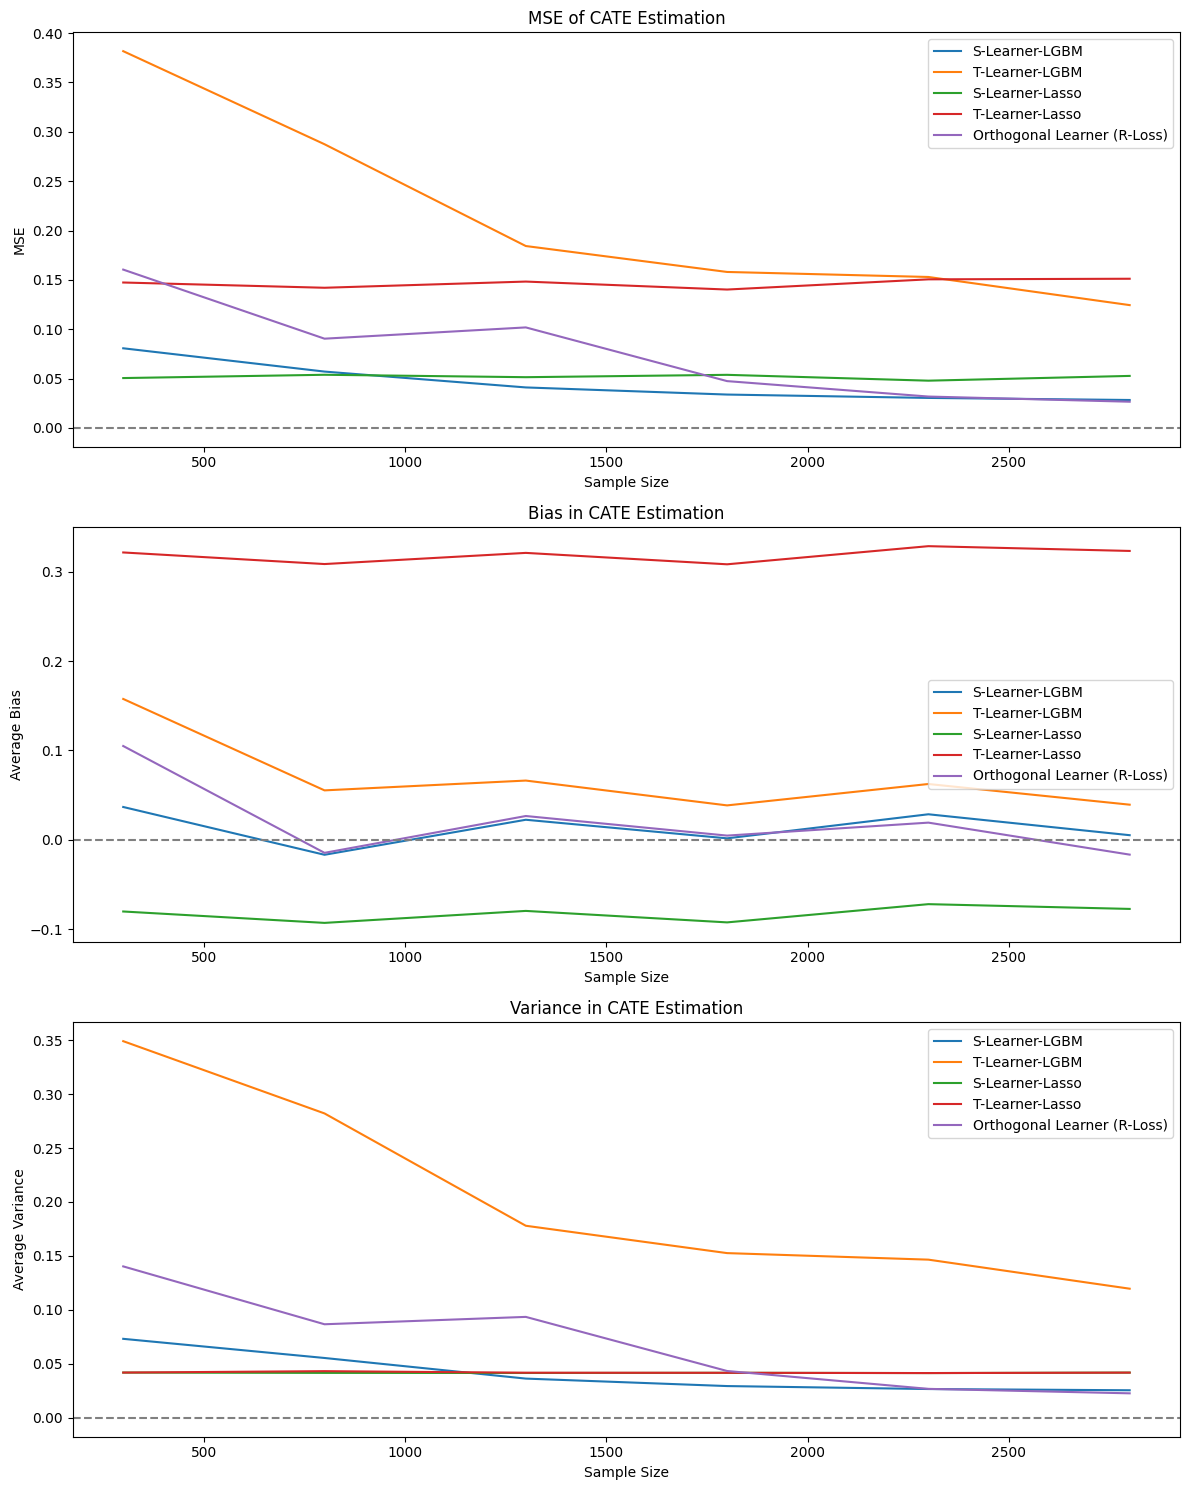

In [80]:
# Add Double ML results (Orthogonal Learning with R-loss)

# # Convergence rate analysis
# n_list = range(300, 3000, 100)
# n_simulation = 5

n_list = range(300, 3000, 500)
n_simulation = 5


# Initialize results
results = {"mse_s": [], "mse_t": [], "bias_s": [], "bias_t": [], "var_s": [], "var_t": [],
           "mse_s2": [], "mse_t2": [], "bias_s2": [], "bias_t2": [], "var_s2": [], "var_t2": [],
           "mse_dml": [], "bias_dml": [], "var_dml": []}

for n in n_list:
    # Temporary storage for simulations
    temp_results = {"s": {"mse": [], "bias": [], "var": []}, "t": {"mse": [], "bias": [], "var": []},
                    "s2": {"mse": [], "bias": [], "var": []}, "t2": {"mse": [], "bias": [], "var": []},
                    "dml": {"mse": [], "bias": [], "var": []}}

    for _ in range(n_simulation):
        gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(n, 6, 1)
        y, T, X, Xtest = gen_data_fn()

        # S-Learner
        mse_s, bias_s, var_s = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=4)
        temp_results["s"]["mse"].append(mse_s['s-learner'])
        temp_results["s"]["bias"].append(bias_s)
        temp_results["s"]["var"].append(var_s)

        # T-Learner
        mse_t, bias_t, var_t = exp(y, T, X, Xtest, [('t-learner', t_learner)], tau_fn, n_x=4)
        temp_results["t"]["mse"].append(mse_t['t-learner'])
        temp_results["t"]["bias"].append(bias_t)
        temp_results["t"]["var"].append(var_t)

        # S-Learner with Lasso
        mse_s2, bias_s2, var_s2 = exp(y, T, X, Xtest, [('s-learner', s_learner_lasso)], tau_fn, n_x=4)
        temp_results["s2"]["mse"].append(mse_s2['s-learner'])
        temp_results["s2"]["bias"].append(bias_s2)
        temp_results["s2"]["var"].append(var_s2)

        # T-Learner with Lasso
        mse_t2, bias_t2, var_t2 = exp(y, T, X, Xtest, [('t-learner', t_learner_lasso)], tau_fn, n_x=4)
        temp_results["t2"]["mse"].append(mse_t2['t-learner'])
        temp_results["t2"]["bias"].append(bias_t2)
        temp_results["t2"]["var"].append(var_t2)

        # Double ML
        mse_dml, bias_dml, var_dml = exp(y, T, X, Xtest, [('dml', dml)], tau_fn, n_x=4)
        temp_results["dml"]["mse"].append(mse_dml['dml'])
        temp_results["dml"]["bias"].append(bias_dml)
        temp_results["dml"]["var"].append(var_dml)


    # Aggregate results for current sample size
    results["mse_s"].append(np.mean(temp_results["s"]["mse"]))
    results["mse_t"].append(np.mean(temp_results["t"]["mse"]))
    results["bias_s"].append(np.mean(temp_results["s"]["bias"]))
    results["bias_t"].append(np.mean(temp_results["t"]["bias"]))
    results["var_s"].append(np.mean(temp_results["s"]["var"]))
    results["var_t"].append(np.mean(temp_results["t"]["var"]))
    results["mse_s2"].append(np.mean(temp_results["s2"]["mse"]))
    results["mse_t2"].append(np.mean(temp_results["t2"]["mse"]))
    results["bias_s2"].append(np.mean(temp_results["s2"]["bias"]))
    results["bias_t2"].append(np.mean(temp_results["t2"]["bias"]))
    results["var_s2"].append(np.mean(temp_results["s2"]["var"]))
    results["var_t2"].append(np.mean(temp_results["t2"]["var"]))
    results["mse_dml"].append(np.mean(temp_results["dml"]["mse"]))
    results["bias_dml"].append(np.mean(temp_results["dml"]["bias"]))
    results["var_dml"].append(np.mean(temp_results["dml"]["var"]))

# Plot the results in a single figure vertically
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Define plot parameters
metrics = ["mse", "bias", "var"]
titles = [
    "MSE of CATE Estimation",
    "Bias in CATE Estimation",
    "Variance in CATE Estimation",
]
ylabels = ["MSE", "Average Bias", "Average Variance"]

# Iterate over metrics to plot
for i, metric in enumerate(metrics):
    axes[i].plot(n_list, results[f"{metric}_s"], label="S-Learner-LGBM")
    axes[i].plot(n_list, results[f"{metric}_t"], label="T-Learner-LGBM")
    axes[i].plot(n_list, results[f"{metric}_s2"], label="S-Learner-Lasso")
    axes[i].plot(n_list, results[f"{metric}_t2"], label="T-Learner-Lasso")
    axes[i].plot(n_list, results[f"{metric}_dml"], label="Orthogonal Learner (R-Loss)")
    axes[i].axhline(y=0 if metric != "mse" else 0, color='gray', linestyle='--')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Sample Size")
    axes[i].set_ylabel(ylabels[i])
    axes[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [81]:
results

{'mse_s': [0.08066151501456177,
  0.057056521062870034,
  0.04099461058566835,
  0.03377562401593279,
  0.030363956788476015,
  0.028265320133429046],
 'mse_t': [0.3817401257439401,
  0.28742941812522227,
  0.1842828317057436,
  0.1580082096011605,
  0.1529246411106286,
  0.12440792913149981],
 'bias_s': [0.036686606875793316,
  -0.016773671744445495,
  0.022407088862293322,
  0.0016250422969721705,
  0.02854303658211447,
  0.00513620862887995],
 'bias_t': [0.15755372191456693,
  0.0552795971699551,
  0.06625028923535034,
  0.03847734321457634,
  0.06240452463503062,
  0.039270125782959416],
 'var_s': [0.07323644969335444,
  0.05549510650128411,
  0.03640151383192638,
  0.02948086847581788,
  0.02672739455896786,
  0.025595378662566552],
 'var_t': [0.3489889487535889,
  0.28204649548019156,
  0.1779873201954726,
  0.15264799123330416,
  0.14659390648350404,
  0.11967716904733257],
 'mse_s2': [0.050489600409462244,
  0.05382277936571742,
  0.05137349157418786,
  0.053764435856425416,
  

# What if switch b_0 and tau_0?

In [82]:
def gen_data(n,d, base_fn, tau_fn, prop_fn, sigma):
    X = np.random.uniform(0,1, size = (n,d))
    X_test = np.random.uniform(0,1, size = (10000, d)) #regardless of train size, we always use 10000 test samples
    T = np.random.binomial(1, prop_fn(X)) #here, 1 refers to number of trials, 1 reduces the binomial distribution to a bernoulli distribution
    y = (T - .5)*tau_fn(X) + base_fn(X) + sigma*np.random.normal(0,1, size = (n,))
    return y, T, X, X_test

def get_data_generator(n, d, sigma):
        def tau_fn(X): return np.sin(np.pi * X[:, 0] * X[:, 1]) + 2*(X[:, 2] - .5)**2 + X[:, 3] + .5*X[:, 4]
        def prop_fn(X): return np.clip(
            np.sin(np.pi * X[:, 0] * X[:, 1]), .2, .8)
        def base_fn(X): return .2 + (X[:, 0] + X[:, 1]) / 2
        def gen_data_fn(): return gen_data(
            n, d, base_fn, tau_fn, prop_fn, sigma)
        return gen_data_fn, base_fn, tau_fn, prop_fn

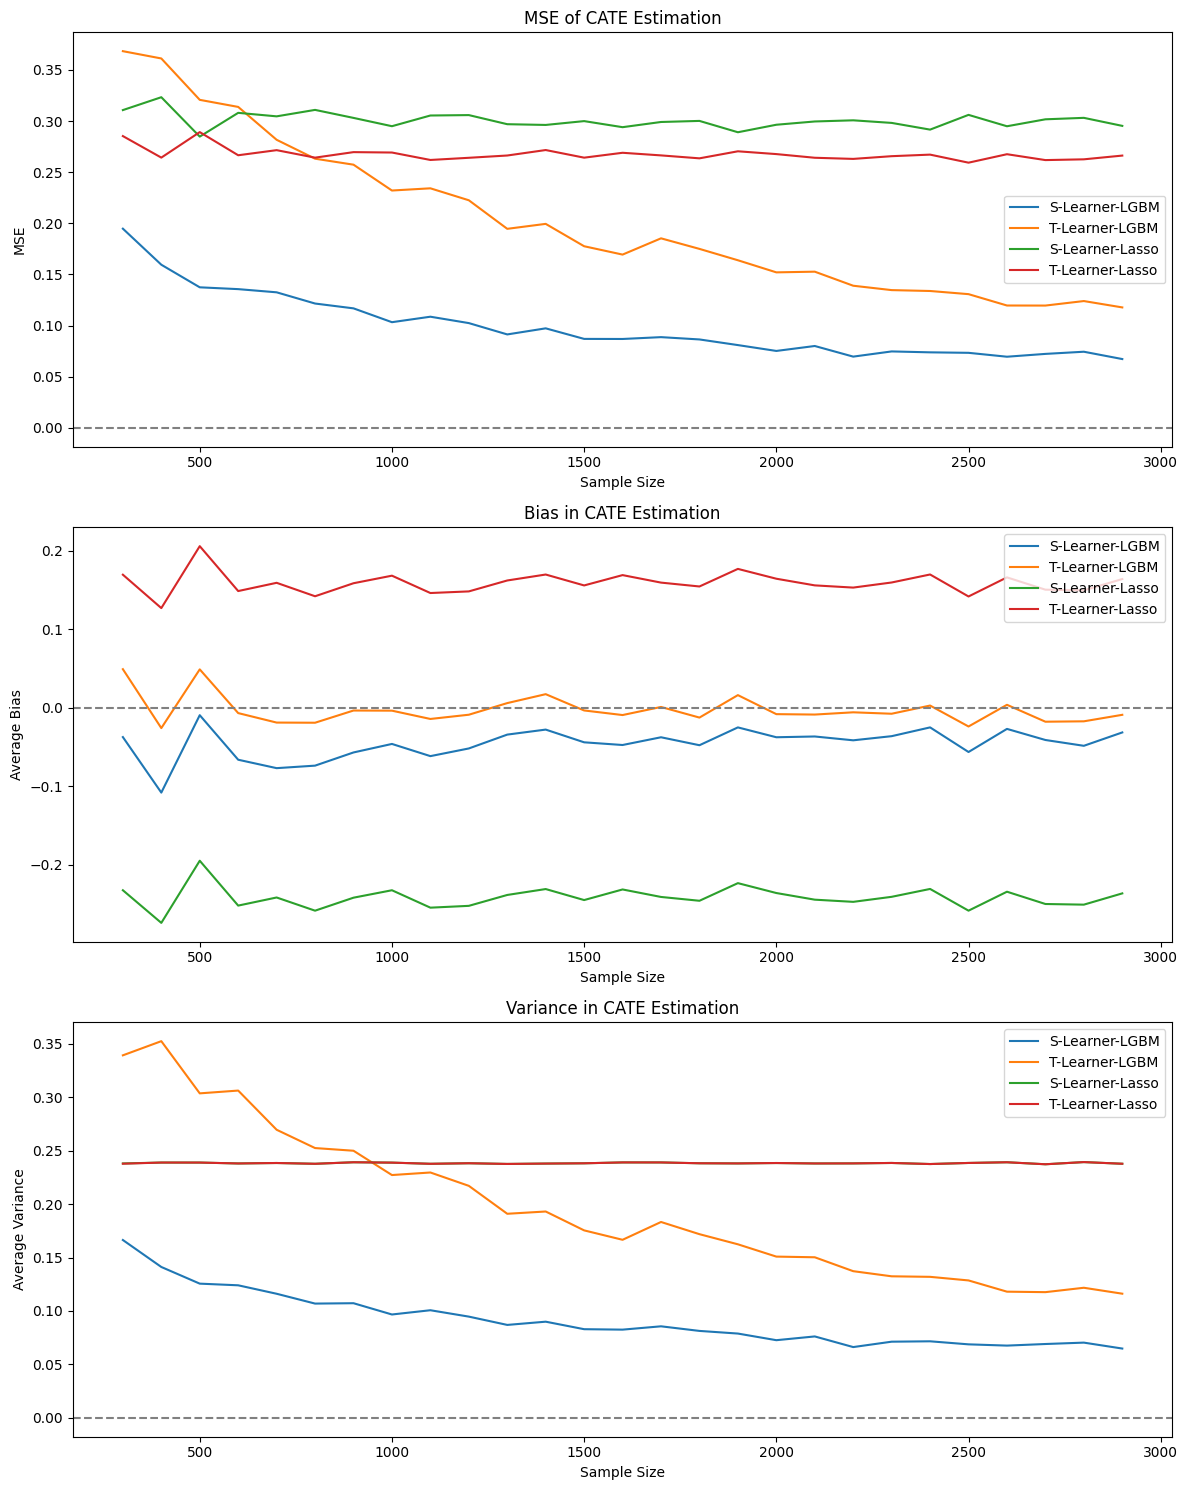

In [83]:
# Convergence rate analysis
n_list = range(300, 3000, 100)
n_simulation = 20

# Initialize results
results = {"mse_s": [], "mse_t": [], "bias_s": [], "bias_t": [], "var_s": [], "var_t": [],
           "mse_s2": [], "mse_t2": [], "bias_s2": [], "bias_t2": [], "var_s2": [], "var_t2": []}

for n in n_list:
    # Temporary storage for simulations
    temp_results = {"s": {"mse": [], "bias": [], "var": []}, "t": {"mse": [], "bias": [], "var": []},
                    "s2": {"mse": [], "bias": [], "var": []}, "t2": {"mse": [], "bias": [], "var": []}}

    for _ in range(n_simulation):
        gen_data_fn, base_fn, tau_fn, prop_fn = get_data_generator(n, 6, 1)
        y, T, X, Xtest = gen_data_fn()

        # S-Learner
        mse_s, bias_s, var_s = exp(y, T, X, Xtest, [('s-learner', s_learner)], tau_fn, n_x=4)
        temp_results["s"]["mse"].append(mse_s['s-learner'])
        temp_results["s"]["bias"].append(bias_s)
        temp_results["s"]["var"].append(var_s)

        # T-Learner
        mse_t, bias_t, var_t = exp(y, T, X, Xtest, [('t-learner', t_learner)], tau_fn, n_x=4)
        temp_results["t"]["mse"].append(mse_t['t-learner'])
        temp_results["t"]["bias"].append(bias_t)
        temp_results["t"]["var"].append(var_t)

        # S-Learner with Lasso
        mse_s2, bias_s2, var_s2 = exp(y, T, X, Xtest, [('s-learner', s_learner_lasso)], tau_fn, n_x=4)
        temp_results["s2"]["mse"].append(mse_s2['s-learner'])
        temp_results["s2"]["bias"].append(bias_s2)
        temp_results["s2"]["var"].append(var_s2)

        # T-Learner with Lasso
        mse_t2, bias_t2, var_t2 = exp(y, T, X, Xtest, [('t-learner', t_learner_lasso)], tau_fn, n_x=4)
        temp_results["t2"]["mse"].append(mse_t2['t-learner'])
        temp_results["t2"]["bias"].append(bias_t2)
        temp_results["t2"]["var"].append(var_t2)

    # Aggregate results for current sample size
    results["mse_s"].append(np.mean(temp_results["s"]["mse"]))
    results["mse_t"].append(np.mean(temp_results["t"]["mse"]))
    results["bias_s"].append(np.mean(temp_results["s"]["bias"]))
    results["bias_t"].append(np.mean(temp_results["t"]["bias"]))
    results["var_s"].append(np.mean(temp_results["s"]["var"]))
    results["var_t"].append(np.mean(temp_results["t"]["var"]))
    results["mse_s2"].append(np.mean(temp_results["s2"]["mse"]))
    results["mse_t2"].append(np.mean(temp_results["t2"]["mse"]))
    results["bias_s2"].append(np.mean(temp_results["s2"]["bias"]))
    results["bias_t2"].append(np.mean(temp_results["t2"]["bias"]))
    results["var_s2"].append(np.mean(temp_results["s2"]["var"]))
    results["var_t2"].append(np.mean(temp_results["t2"]["var"]))

# Plot the results in a single figure vertically
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Define plot parameters
metrics = ["mse", "bias", "var"]
titles = [
    "MSE of CATE Estimation",
    "Bias in CATE Estimation",
    "Variance in CATE Estimation",
]
ylabels = ["MSE", "Average Bias", "Average Variance"]

# Iterate over metrics to plot
for i, metric in enumerate(metrics):
    axes[i].plot(n_list, results[f"{metric}_s"], label="S-Learner-LGBM")
    axes[i].plot(n_list, results[f"{metric}_t"], label="T-Learner-LGBM")
    axes[i].plot(n_list, results[f"{metric}_s2"], label="S-Learner-Lasso")
    axes[i].plot(n_list, results[f"{metric}_t2"], label="T-Learner-Lasso")
    axes[i].axhline(y=0 if metric != "mse" else 0, color='gray', linestyle='--')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Sample Size")
    axes[i].set_ylabel(ylabels[i])
    axes[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()